<a href="https://colab.research.google.com/github/Masum06/Automated-Ataxia-Gait/blob/main/(working)_Object_Detection_and_MOT_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multiple Object Tracking with PyTorch**



---
**Reference**



*   Object Detection with Faster R-CNN: https://www.learnopencv.com/faster-r-cnn-object-detection-with-pytorch/ 
*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking: https://arxiv.org/abs/1602.00763


**Question**
: What is Multiple Object Tracking?
- Object tracking is one of the tasks in computer vision, which is detecting an object and searching for that object in a video or a series of images (actually both meaning the same thing). 
- Surveillance cameras in public places for spotting suspicious activities or crimes, and a computer system called 'Hawk-eye' for tracking the trajectory of the ball in various sports are typical examples of applying object tracking in a real life.


**Goals**


1. We will use MOT17Det Dataset
2. First part: Object Detection with **Faster R-CNN**
3. Second part: Multiple Object(ID) Tracking with  **Simple Online and Realtime Tracking (SORT)** algorithm



---




**0. Preparation**


*   For your convenience, it is recommended to mount your Google Drive first.
*   Then create extra space for this tutorial in there.


---






In [ ]:
# from google.colab import drive
root = './'
# drive.mount(root)

In [ ]:
# Making Directory

import os 
from os.path import join

# mot = "My Drive/Colab Notebooks/MOT/"   # a custom path. you can change if you want to
MOT_PATH = 'MOT/' # join(root,mot)
!mkdir "{MOT_PATH}"



---


**1. Dataset**


*   https://motchallenge.net/ : MOT17Det Dataset for Pedestrian Detection Challenge
*   We will only use MOT17-09 dataset for our task.


---






In [ ]:
# Download MOT17Det Dataset

!wget -P "{MOT_PATH}" https://motchallenge.net/data/MOT17Det.zip
!cd "{MOT_PATH}";unzip MOT17Det.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/MOT17-02/img1/000323.jpg  
  inflating: train/MOT17-02/img1/000324.jpg  
  inflating: train/MOT17-02/img1/000325.jpg  
  inflating: train/MOT17-02/img1/000326.jpg  
  inflating: train/MOT17-02/img1/000327.jpg  
  inflating: train/MOT17-02/img1/000328.jpg  
  inflating: train/MOT17-02/img1/000329.jpg  
  inflating: train/MOT17-02/img1/000330.jpg  
  inflating: train/MOT17-02/img1/000331.jpg  
  inflating: train/MOT17-02/img1/000332.jpg  
  inflating: train/MOT17-02/img1/000333.jpg  
  inflating: train/MOT17-02/img1/000334.jpg  
  inflating: train/MOT17-02/img1/000335.jpg  
  inflating: train/MOT17-02/img1/000336.jpg  
  inflating: train/MOT17-02/img1/000337.jpg  
  inflating: train/MOT17-02/img1/000338.jpg  
  inflating: train/MOT17-02/img1/000339.jpg  
  inflating: train/MOT17-02/img1/000340.jpg  
  inflating: train/MOT17-02/img1/000341.jpg  
  inflating: train/MOT17-02/img1/000342.jpg  
  inflating: train/MOT17-02/i

In [ ]:
# Remove unwanted data for drive volume issue (optional)

# !cd "{MOT_PATH}";rm -rf test
# !cd "{MOT_PATH}";rm -rf train/MOT17-02;rm -rf train/MOT17-04;rm -rf train/MOT17-05
# !cd "{MOT_PATH}";rm -rf train/MOT17-10;rm -rf train/MOT17-11;rm -rf train/MOT17-13

In [ ]:
import sys

motdata = join(MOT_PATH,'train/MOT17-09/img1/')
sys.path.append(motdata)

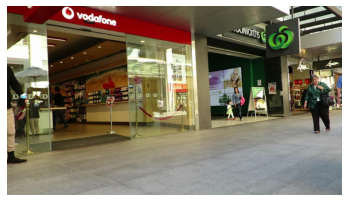

In [ ]:
# Example: Original picture before detection

import matplotlib.pylab as plt
import cv2

list_motdata = os.listdir(motdata)  
list_motdata.sort()

img_ex_path = motdata + list_motdata[0]
img_ex_origin = cv2.imread(img_ex_path)
img_ex = cv2.cvtColor(img_ex_origin, cv2.COLOR_BGR2RGB)

plt.imshow(img_ex)
plt.axis('off')
plt.show()




---


**2. Object Detection with Faster R-CNN**

*  We will use a pretrained Faster R-CNN model using ResNet50 as a backbone with FPN.





---




In [ ]:
# Import required packages/modules first

from PIL import Image
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

In [ ]:
# Download the pretrained Faster R-CNN model from torchvision

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)#.cuda()
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# Define the class names given by PyTorch's official Docs

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]


In [ ]:
# Defining a function for get a prediction result from the model

def get_prediction(img_path, threshold):
  img = Image.open(img_path).convert('RGB') # Load the image
  transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
  img = transform(img) # Apply the transform to the image
  pred = model([img]) # Pass the image to the model
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
  pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return pred_boxes, pred_class 

In [ ]:
threshold = 0.8
import time


img = Image.open(img_ex_path) # Load the image
transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform
img = transform(img) # Apply the transform to the image
start = time.time()
pred = model([img]) # Pass the image to the model
end = time.time()
print(end - start)

7.65424108505249


In [ ]:
img.shape

torch.Size([3, 1080, 1920])

In [ ]:
pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())] # Get the Prediction Score
pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())] # Bounding boxes
pred_score = list(pred[0]['scores'].detach().numpy())
pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
pred_boxes = pred_boxes[:pred_t+1]
pred_class = pred_class[:pred_t+1]
pred_class

['person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'person',
 'umbrella',
 'person',
 'handbag']

In [ ]:
# Defining a api function for object detection
 
def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):
 
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
    cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  plt.figure(figsize=(15,20)) # display the output image
  # cv2.imwrite('fig 2- bounding box.png', img)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

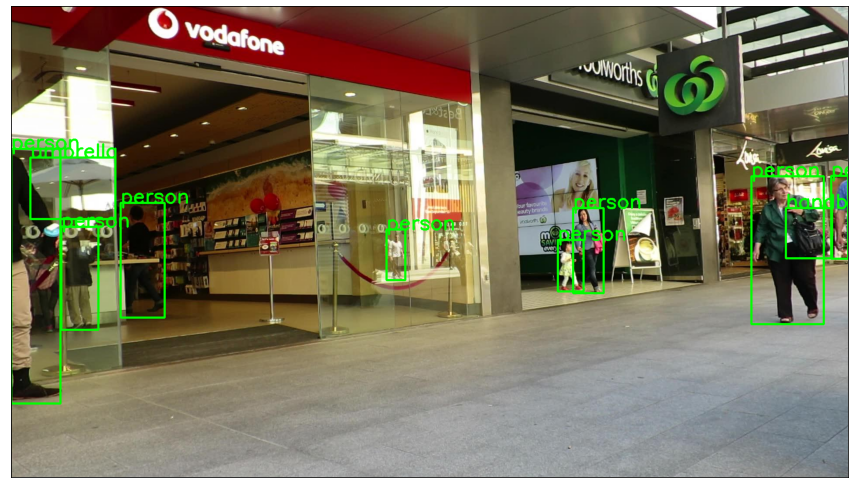

In [ ]:
# Example: After detection
object_detection_api(img_ex_path,threshold=0.8)

In [ ]:
patient = cv2.imread('fig 1- patient doctor.png')
patient.shape

(1328, 1930, 3)

In [ ]:
img.shape

torch.Size([3, 1080, 1920])

In [ ]:
ataxia_path = 'fig 1- patient doctor.png'

In [ ]:
# Example: After detection
object_detection_api(ataxia_path, threshold=0.8)

In [ ]:
def crop_img(img, box):
  h = int(-box[0][1]+box[1][1]+0.5)
  w = int(-box[0][0]+box[1][0]+0.5)
  y = int(box[0][1]+0.5)
  x = int(box[0][0]+0.5)
  b = int(0.02*h)
  cropped_img = img[max(0,y-b):min(y+h+b, len(img)), max(0,x-b):min(x+w+b, len(img[0]))]
  return cropped_img

In [ ]:
def show_person(img_path, threshold=0.5, rect_th=3, text_size=1.5, text_th=3):
 
  boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
  img = cv2.imread(img_path) # Read image with cv2
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
  for i in range(len(boxes)):
    if pred_cls[i] == 'person':
      break
  cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
  # cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
  print(boxes[i])
  cropped_img = crop_img(img, boxes[i])
  plt.figure(figsize=(5,7)) # display the output image
  plt.imshow(cropped_img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

In [ ]:
img_ex_path

'MOT/train/MOT17-09/img1/000001.jpg'

In [ ]:
show_person(ataxia_path,threshold=0.8)





*   The picture above is an example of applying Detection Network (in our case, Faster R-CNN).
*   Since the purpose of dataset we are using is 'tracking', you can see that most of the detected classes are 'person'.
*   We need a prediction result (bbs offset, class label, pred scores) for all the images.






---


**3. Object ID Tracking with SORT**


*   Simple Online and Realtime Tracking (SORT) algorithm for object ID tracking 

---



In [ ]:
# Git clone: SORT Algorithm

!cd "{MOT_PATH}";git clone https://github.com/abewley/sort.git
  
sort = join(MOT_PATH,'sort/')
sys.path.append(sort)

Cloning into 'sort'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 202 (delta 0), reused 0 (delta 0), pack-reused 198
Receiving objects: 100% (202/202), 1.21 MiB | 7.63 MiB/s, done.
Resolving deltas: 100% (69/69), done.


In [ ]:
# requirement for sort
!cd "{sort}";pip install -r requirements.txt

     |████████████████████████████████| 177 kB 5.3 MB/s 
     |████████████████████████████████| 12.5 MB 27.8 MB/s 
     |████████████████████████████████| 1.5 MB 38.6 MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110474 sha256=ad95bf42d040d6cdc48166dccaea1238edcb4118ce76cf0edfa09827d74d5a07
  Stored in directory: /root/.cache/pip/wheels/ce/e0/ee/a2b3c5caab3418c1ccd8c4de573d4cbe13315d7e8b0a55fbc2
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1590164 sha256=5cc096b6a552fc390273602ac087b3077be519cf435e942e26aef4a35d015408
  Stored in directory: /root/.cache/pip/wheels/b1/0b/e3/ef9daf1b5547b56389e42c80c3100f1e6479bf5fd00fd9d6ba
Successfully built filterpy lap
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages th

In [ ]:
# Optional: if error occurs, you might need to re-install scikit-image and imgaug

!pip uninstall scikit-image -y
!pip uninstall imgaug -y
!pip install imgaug
!pip install -U scikit-image

import skimage
print(skimage.__version__)

Found existing installation: scikit-image 0.17.2
Uninstalling scikit-image-0.17.2:
  Successfully uninstalled scikit-image-0.17.2
Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 948 kB 4.7 MB/s 
     |████████████████████████████████| 13.3 MB 19.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.
0.19.1


In [ ]:
# Detection information on all the images is well-refined as a json file, which is available at our course git repo

!cd "{MOT_PATH}";git clone https://github.com/mlvlab/COSE474.git

Cloning into 'COSE474'...
remote: Enumerating objects: 186, done.
remote: Total 186 (delta 0), reused 0 (delta 0), pack-reused 186
Receiving objects: 100% (186/186), 40.65 MiB | 27.64 MiB/s, done.
Resolving deltas: 100% (99/99), done.


In [ ]:
!export MPLBACKEND=TKAgg

In [ ]:
import matplotlib
matplotlib.use('TKAgg')
import matplotlib.pyplot as plt

In [ ]:
import json
import collections
from pprint import pprint
from sort import *

jsonpath = join(MOT_PATH,'COSE474/3_MOT_detinfo.json')

with open(jsonpath) as data_file:    
   data = json.load(data_file)
odata = collections.OrderedDict(sorted(data.items()))

/usr/local/lib/python3.7/dist-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


In [ ]:
# Let's check out downloaded json file

pprint(odata)

Streaming output truncated to the last 5000 lines.
                'scores': 0.9063880443572998},
               {'bbox': [34.13352966308594,
                         355.93682861328125,
                         85.53865051269531,
                         401.1189270019531],
                'labels': 68,
                'scores': 0.8869121670722961},
               {'bbox': [1317.8665771484375,
                         566.4204711914062,
                         1369.163818359375,
                         642.6348266601562],
                'labels': 27,
                'scores': 0.8799705505371094},
               {'bbox': [1227.9986572265625,
                         579.244873046875,
                         1272.51025390625,
                         648.2922973632812],
                'labels': 27,
                'scores': 0.7431402206420898}]),
             ('000459.jpg',
              [{'bbox': [76.42948150634766,
                         150.27622985839844,
                    



---



*   For each image, bbs offset, class label, pred scores are all annotated.
*   Labels are annotated as a number - not a word, and for further information, go to the website below.
* https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/ 



---



In [ ]:
img_path = motdata    # img root path

# Making new directory for saving results
save_path = join(MOT_PATH,'save/')
!mkdir "{save_path}"

In [ ]:
mot_tracker = Sort()      # Tracker using SORT Algorithm

In [ ]:
for key in odata.keys():
    arrlist = []
    det_img = cv2.imread(os.path.join(img_path, key))
    overlay = det_img.copy()
    det_result = data[key] # find the format from det_result and put the info from prediction
    
    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox+[scores]
        
        if labels == 1: # label 1 is a person in MS COCO Dataset
            arrlist.append(templist)
            
    track_bbs_ids = mot_tracker.update(np.array(arrlist))
    
    mot_imgid = key.replace('.jpg','')
    newname = save_path + mot_imgid + '_mot.jpg'
    print(mot_imgid)
    
    for j in range(track_bbs_ids.shape[0]):  
        ele = track_bbs_ids[j, :]
        x = int(ele[0])
        y = int(ele[1])
        x2 = int(ele[2])
        y2 = int(ele[3])
        track_label = str(int(ele[4])) 
        cv2.rectangle(det_img, (x, y), (x2, y2), (0, 255, 255), 4)
        cv2.putText(det_img, '#'+track_label, (x+5, y-10), 0,0.6,(0,255,255),thickness=2)
        
    cv2.imwrite(newname,det_img)

000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049
000050
000051
000052
000053
000054
000055
000056
000057
000058
000059
000060
000061
000062
000063
000064
000065
000066
000067
000068
000069
000070
000071
000072
000073
000074
000075
000076
000077
000078
000079
000080
000081
000082
000083
000084
000085
000086
000087
000088
000089
000090
000091
000092
000093
000094
000095
000096
000097
000098
000099
000100
000101
000102
000103
000104
000105
000106
000107
000108
000109
000110
000111
000112
000113
000114
000115
000116
000117
000118
000119
000120
000121
000122
000123
000124
000125
000126
000127
000128
000129
000130
000131
000132
000133
000134
000135
000136
000137
000138
000139
000140
000141
000142
000143

## SORT algorithm from direct prediction

**Display image**

In [ ]:
from google.colab.patches import cv2_imshow
import math

def resize_and_show(image):
  DESIRED_HEIGHT = 720
  DESIRED_WIDTH = 720
  h, w = image.shape[:2]
  if h < w:
    img = cv2.resize(image, (DESIRED_WIDTH, math.floor(h/(w/DESIRED_WIDTH))))
  else:
    img = cv2.resize(image, (math.floor(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
  cv2_imshow(img)

In [ ]:
def crop_coordinate(img, x1,y1,x2,y2):
  h = int(-y1+y2+0.5)
  w = int(-x1+x2+0.5)
  y = int(y1+0.5)
  x = int(x1+0.5)
  b = int(0.02*h)
  cropped_img = img[max(0,y-b):min(y+h+b, len(img)), max(0,x-b):min(x+w+b, len(img[0]))]
  return cropped_img

In [ ]:
frame_h = img.shape[1]
frame_w = img.shape[2]
(frame_h, frame_w)

(1080, 1920)

In [ ]:
transform = T.Compose([T.ToTensor()]) # Defing PyTorch Transform

def format_pred(img_path, min_score):
  image = Image.open(img_path) # Load the image
  image = transform(image).cuda() # Apply the transform to the image
  pred = model([image])
  mask = (pred[0]['labels'] == 1) & (pred[0]['scores'] > min_score)
  boxes = pred[0]['boxes'][mask].tolist()
  labels = pred[0]['labels'][mask].tolist()
  scores = pred[0]['scores'][mask].tolist()
  
  det_list = []
  for i in range(len(boxes)):
    box = boxes[i]
    label = labels[i]
    score = scores[i]
    det_list.append({'bbox':box, 'labels':1, 'scores':score})

  return det_list

In [ ]:
det_img = cv2.imread('MOT/save/000007_mot.jpg')
resize_and_show(det_img)

In [ ]:
mot_tracker = Sort()

In [ ]:
for key in odata.keys(): # Change this to video frame by frame reading
    arrlist = []
    det_img = cv2.imread(os.path.join(img_path, key))
    # overlay = det_img.copy()
    det_result = format_pred(os.path.join(img_path, key), 0.9) #data[key] 
    # find the format from det_result and put the info from prediction
    print(key)

    for info in det_result:
        bbox = info['bbox']
        labels = info['labels']
        scores = info['scores']
        templist = bbox+[scores]
        
        if labels == 1: # label 1 is a person in MS COCO Dataset
            arrlist.append(templist)
            
    track_bbs_ids = mot_tracker.update(np.array(arrlist))
    
    # mot_imgid = key.replace('.jpg','')
    # newname = save_path + mot_imgid + '_mot.jpg'
    # print(mot_imgid)
    
    for j in range(track_bbs_ids.shape[0]):  
        ele = track_bbs_ids[j, :]
        x = int(ele[0])
        y = int(ele[1])
        x2 = int(ele[2])
        y2 = int(ele[3])
        track_label = str(int(ele[4])) 
        
        # crop each person with x,y,x2,y2
        cropped_img = crop_coordinate(det_img, x,y,x2,y2)
        # identify landmarks
        # make a directory for 'track_label'
        # save if full human visible. discard if width below 
        if not os.path.exists('MOT/save/'+track_label):
            os.makedirs('MOT/save/'+track_label)
        # save cropped video and landmark data in separate folders
        cv2.imwrite('MOT/save/'+track_label+'/per_'+track_label+'_'+key, cropped_img)

In [ ]:
!rm -r MOT/save/*

In [ ]:
track_bbs_ids


---
It's all done!


*   Finally, you can get a sequence of image with each Tracking ID for every detected person. 
*   Check '3_MOT_result.gif' for whole demo experience.



---




In [ ]:
!apt-get install tree

In [ ]:
!tree MOT

In [ ]:
!zip -r detected.zip MOT/save 